In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

# os.chdir('/content/drive/My Drive/datasets')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 180, brightness_range=(0.1,1.8))
testgen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/qc-camera-inspection/dataset3/Dataset/Train',
        # '/content/drive/MyDrive/NEU Metal Surface Defects Data/train',
        classes = ['Glare','Ok','Scratch'],
        # classes = ['Rolled', 'Scratches' ,'Patches', 'Pitted', 'Inclusion','Crazing'],
        target_size=(100, 100),
        # subset='training',
        batch_size=32)

validation_generator = testgen.flow_from_directory(
        '/content/drive/MyDrive/qc-camera-inspection/dataset3/Dataset/Validasi',
        # '/content/drive/MyDrive/NEU Metal Surface Defects Data/valid',
        # classes = ['Rolled', 'Scratches' ,'Patches', 'Pitted', 'Inclusion','Crazing'],
        classes = ['Glare','Ok','Scratch'],
        target_size=(100, 100),
        # subset='validation',
        batch_size=32
         )

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model


image_size = 100
input_shape = (image_size, image_size, 3)

batch_size = 10

base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

for layer in base_model.layers[:15]:
    layer.trainable = False

for layer in base_model.layers[15:]:
    layer.trainable = True

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=8e-6),
              metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_generator, validation_data = validation_generator, epochs = 1400)

Epoch 1/1400
7/7 [==============================] - 1s 174ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2223 - val_accuracy: 0.9200
Epoch 2/1400
7/7 [==============================] - 1s 168ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2235 - val_accuracy: 0.9200
Epoch 3/1400
7/7 [==============================] - 1s 164ms/step - loss: 0.0287 - accuracy: 0.9900 - val_loss: 0.2226 - val_accuracy: 0.9200
Epoch 4/1400
7/7 [==============================] - 1s 164ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.2208 - val_accuracy: 0.9200
Epoch 5/1400
7/7 [==============================] - 1s 162ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2227 - val_accuracy: 0.9200
Epoch 6/1400
7/7 [==============================] - 1s 161ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.2228 - val_accuracy: 0.9200
Epoch 7/1400
7/7 [==============================] - 1s 161ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.2211 - val_accuracy: 0.9200
Epoch 

2/2 [==============================] - 0s 45ms/step


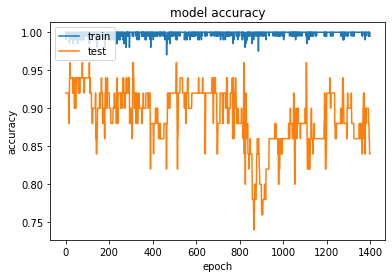

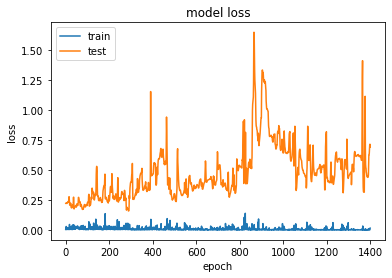

In [ ]:
import matplotlib.pyplot as plt

model.evaluate(validation_generator)
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('qc-v5.h5')

Sigmoid result: [0.5015921  0.7282902  0.50191665] - Prediction: Ok - Confidence: 72.829 %


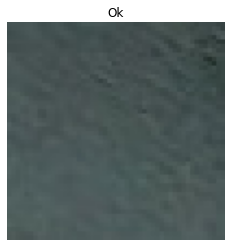

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow as tf
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

# classes_multi = ['Rolled', 'Scratches' ,'Patches', 'Pitted', 'Inclusion','Crazing']
classes_multi = ['Glare','Ok','Scratch']
img = image.load_img('/content/drive/MyDrive/qc-camera-inspection/dataset3/Dataset/Test/Ok/ok(82).jpg', target_size=(100, 100)) #type nya PIL.image
# img = image.load_img('/content/Image16.jpg', target_size=(700, 700)) #type nya PIL.image
x = image.img_to_array(img) #ubah5 ke np.ndarray, or just use cv.imread() udah langsung np.ndarray (shape dan dim udah sama juga)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

# FOR BINARY CLASSIFICATION
# pred_bin = model_bin.predict(images)
# sigmoid_bin = tf.nn.sigmoid(pred_bin[0]).numpy()
# sigmoid_bin01 = tf.where(sigmoid_bin < 0.5, 0, 1)
# # print(sigmoid_bin)
# # print(sigmoid_bin01)
# maks = 0
# for i in range (0,2):
#     if sigmoid_bin[i] > maks:
#       maks = sigmoid_bin[i]
#       label_bin = classes_bin[i]
#       print (sigmoid_bin[i])

# FOR MULTI CLASS CLASSIFICATION
pred_multi = model.predict(images)
# print(len(sigmoid_multi))
sigmoid_multi = tf.nn.sigmoid(pred_multi[0]).numpy()
for i in range(len(sigmoid_multi)):
    if sigmoid_multi[i] == max(sigmoid_multi):
        sigmoid_multi_max = sigmoid_multi[i]
        label_multi = classes_multi[i]
        class_number = i
        break

print(f'Sigmoid result: {sigmoid_multi} - Prediction: {label_multi} - Confidence: {round(sigmoid_multi_max*100, 3)} %')
# print(f'Sigmoid result: {sigmoid_bin} - Prediction: {label_bin} - {round(maks*100, 1)} %')

plt.figure()
plt.axis('off')
plt.title(label_multi)
result = plt.imshow(img)
plt.show()

In [ ]:
# label = ['Rolled', 'Scratches' ,'Patches', 'Pitted', 'Inclusion','Crazing']

# %matplotlib inline
# import numpy as np
# from google.colab import files
# from keras.preprocessing import image


# # predicting images
# path = '/content/RS_10.bmp'
# img = image.load_img(path, target_size=(224, 224))
# x = image.img_to_array(img)
# plt.imshow(x/255.)
# x = np.expand_dims(x, axis=0)
# images = np.vstack([x])
# classes = model.predict(images, batch_size=10)
# print(classes[0])
# print(label[np.argmax(classes[0])])
